# Simple unicycle model of a UAV #

In [135]:
%matplotlib inline
import pdb
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def UAVmodel(state,u,dt):
    # unpack the state vector
    x = state[0]
    y = state[1]
    theta = state[2]

    # unpack the input vectors
    v = u[0]
    w = u[1]

    # compute deltas
    dx = v*np.cos(theta)*dt
    dy = v*np.sin(theta)*dt
    dtheta = w*dt
    
    # new state
    new_state = np.zeros(3)
    new_state[0] = x + dx
    new_state[1] = y + dy
    new_state[2] = theta + dtheta
    
    # return the two state derivatives
    return new_state

def simpleUAVmodelTestandPlot():
    n = 1000
    state = np.zeros([3,n])
    state[:,0] = [0.0, 0.0, 0.0]

    for i in range(1,n):
        state[:,i] = UAVmodel(state[:,i-1],[1,5],0.001)


    plt.plot(state[0,:], state[1,:]);
    plt.xlabel('x');
    plt.ylabel('y');


# The Vector-Field VF(x) #
based on the implicit funtion $\phi$ as taken from Goncalves2010a

In [136]:
import numpy as np

def VF_G(y):
    return -2/np.pi*np.arctan(10*y)
def VF_phi(x):
    return np.power(x[0],4)/16-2*np.power(x[0],2)*np.power(x[1],2)/5+np.power(x[1],4)-1
def VF_phi_grad(x):
    grad = np.zeros(2)
    grad[0] = 1/4*np.power(x[0],3)-4/5*x[0]*np.power(x[1],2)
    grad[1] = 4*np.power(x[1],3)-4/5*x[1]*np.power(x[0],2)
    return grad
def VF_alpha(x):
    return VF_G(VF_phi(x))
def VF_N(x):
    return np.multiply(VF_alpha(x), VF_phi_grad(x))
def VF_H(x):
    return 1
def VF_beta(x):
    return VF_H(VF_phi(x))
def VF_T(x):
    phi_grad = VF_phi_grad(x)
    return VF_beta(x) * [-phi_grad[1],phi_grad[0]]
def VF(x):
    return VF_N(x) + VF_T(x)

#print(VF_phi([0,-1])==0)
#print(VF_phi([-2,0])==0)
#print(VF_phi_grad([0,-1]))
#print(VF_phi_grad([-2,0]))
#print(VF([0,-1])==[ 4.,  0.])
#print(VF([-2,0])==[ 0., -2.])


## Approximate Distance to Implicit Curve ##

In [137]:
from numpy import linalg as LA
from math import atan2
import numpy as np

def approxPointOnImplicitCurve(x,f,df,tangent_function):
    #TODO: Maybe use approximation from Taubin1994 instead of numerical approach
    eps = 0.1 # tuning parameter
    step = 0.05 # tuning parameter
    
    # Offset, to make sure the UAV rotates in the intended direction
    scaling_tangent = 0.1 # tuning parameter
    
    # Gradient descent, better would be Newton or quasi Newton 
    x_temp = x
    i = 0
    while np.power(f(x_temp),2)>eps and i<100:
        grad = df(x_temp)
        grad /= LA.norm(grad)
        x_temp = x_temp - grad*step
        i = i + 1
        #if i>100:
        #    pdb.set_trace()
    #print(i)
    #tangent_on_curve = np.array(tangent_function(x_temp))
    #tangent_on_curve /= LA.norm(tangent_on_curve)
    
    x_on_curve = x_temp #+ tangent_on_curve*scaling_tangent # TODO should be '+' for normal behavior
    
    return x_on_curve
#print(approxDist(np.array([0,-1]),VF_phi,VF_phi_grad)==0)
print(approxPointOnImplicitCurve(np.array([0,-1.5]),VF_phi,VF_phi_grad,VF_T))
#print(approxDist(np.array([-2,0]),VF_phi,VF_phi_grad)==0)

def angleOfTangent(x,tangent_function):
    tangent_on_curve = np.array(tangent_function(x))
    return atan2(tangent_on_curve[1],tangent_on_curve[0])
#print(angleOfTangent(np.array([0,-1]),VF_T))
#print(angleOfTangent(np.array([-2,0]),VF_T))


[ 0.   -1.05]


# Cost Function and Constraints #

In [138]:
from numpy import linalg as LA
import numpy as np


def J(xk,H_p,H_c,V,W,q,weights,t_step,int_t_step,angle_error_weight):
    if len(V)!=H_c or len(W)!=H_c:
        raise ValueError('Number of Inputs of U is not equivalent to control horizon H_c')
    
    # simulate H_p steps beginning at the current measurement xk
    x=tuple()
    x = x + (xk,)
    for l in np.arange(0,H_p):
        #pdb.set_trace()
        x_temp = x[l]
        for i in np.arange(0,t_step,int_t_step):
            if l<H_c:
                x_temp = UAVmodel(x_temp,[V[l],W[l]],int_t_step)
            else:
                x_temp = UAVmodel(x_temp,[V[-1],W[-1]],int_t_step)
        x = x + (x_temp,)
    
    # Calculate Weighted State Errors
    errors = np.zeros(H_p)
    #print('state error')
    for i in np.arange(0,H_p):
        pos = x[i][0:2]
        theta = x[i][-1]
        curve_pos = approxPointOnImplicitCurve(pos,VF_phi,VF_phi_grad,VF_T)
        curve_theta = angleOfTangent(curve_pos,VF_T)
        theta_diff = atan2(np.sin(theta-curve_theta), np.cos(theta-curve_theta))*angle_error_weight
        errors[i] = LA.norm(np.hstack([pos-curve_pos,theta_diff]))
        #errors[i] = LA.norm(pos-curve_pos)
        #print(errors[i])
    Q = np.eye(H_p)*q
    sumOfStateErrors = np.dot(np.dot(errors,Q),errors)
        
    # Weighted Input Term
    sumOfWeightedInputs = np.dot(np.absolute(W),weights)
    #print('input punishment')
    #print(sumOfWeightedInputs)

    return sumOfStateErrors + sumOfWeightedInputs

def generateBounds(H_c,b_l,b_u):
    bnds = tuple()
    for i in range(0,H_c):
        bnds = ((b_l, b_u),) + bnds
    return bnds


# Visualization #

In [139]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def plotTraj(xk,Model,V,W,t_step,int_t_step):
    # simulate H_p steps beginning at the current measurement xk
    x=tuple()
    x = x + (xk,)
    for l in np.arange(0,len(V)):
        #pdb.set_trace()
        x_temp = x[l]
        for i in np.arange(0,t_step,int_t_step):
            x_temp = Model(x_temp,[V[l],W[l]],int_t_step)
        x = x + (x_temp,)
    #pdb.set_trace()
    x_all = np.vstack(x)
    plt.plot(x_all[:,0],x_all[:,1]);
    plt.xlabel('x');
    plt.ylabel('y');

def plotTrajCost(xk,Model,V,W,t_step,int_t_step,weights,q):
    # simulate H_p steps beginning at the current measurement xk
    x=tuple()
    x = x + (xk,)
    N = len(V)
    errors = np.zeros(N)
    inputs = np.zeros(N)
    for l in np.arange(0,len(V)):
        #pdb.set_trace()
        x_temp = x[l]
        for i in np.arange(0,t_step,int_t_step):
            x_temp = Model(x_temp,[V[l],W[l]],int_t_step)
        x = x + (x_temp,)
        pos = x_temp[0:2]
        theta = x_temp[-1]
        curve_pos = approxPointOnImplicitCurve(pos,VF_phi,VF_phi_grad,VF_T)
        curve_theta = angleOfTangent(curve_pos,VF_T)
        theta_diff = atan2(np.sin(theta-curve_theta), np.cos(theta-curve_theta))
        errors[l] = np.power(LA.norm(np.hstack([pos-curve_pos,theta_diff])),2)*q
        inputs[l] = np.absolute(W[l])*weights[l]
    #pdb.set_trace()
    plt.plot(range(0,N),errors,label='state error')
    plt.plot(range(0,N),inputs,label='weighted input')
    plt.plot(range(0,N),errors+inputs,label='sum')
    
    plt.xlabel('inputs');
    plt.ylabel('error');
    #plt.legend()
    #plt.show()
    
def plotImplCurve(implfun,xmin,xmax,ymin,ymax,eps,N):
    #N = 100
    #eps = 2e-3
    x = np.linspace(xmin, xmax, N)
    y = np.linspace(ymin, ymax, N)

    X, Y = np.meshgrid(x, y)
    Z = np.zeros([N,N])
    for i in range(0,N):
        for j in range(0,N):
            if np.power(implfun([X[i,j],Y[i,j]]),2)<=eps:
                #print(implfun([X[i,j],Y[i,j]]))
                plt.plot(X[i,j],Y[i,j],'o',color='blue')
    #plt.show()


# MPC Control #

 success: True
 message: 'Optimization terminated successfully.'
    nfev: 149
     fun: 301.86418094345282
   maxcv: 0.0
  status: 1
       x: array([-0.48803253, -0.4765174 , -0.42820116, -0.22649036, -0.02678218,
       -0.00717694, -0.27210409, -0.04547215,  0.05064173, -0.83629272])


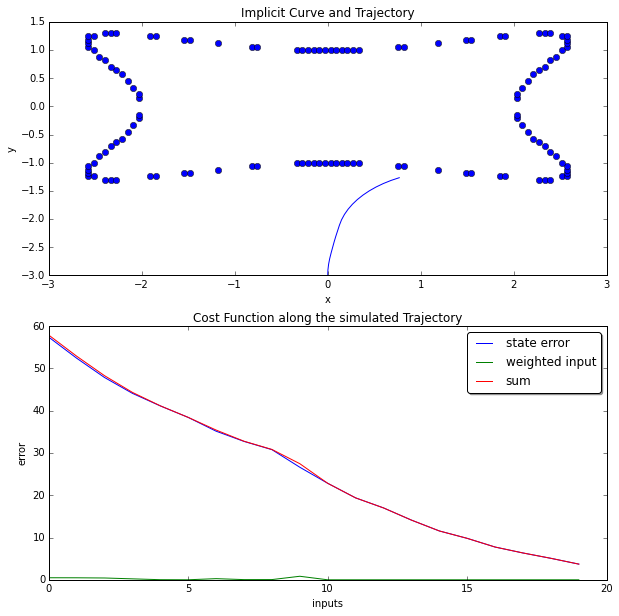

In [141]:
from scipy.optimize import minimize
from scipy.optimize import brute
import matplotlib.pyplot as plt

# related to plots
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
#from matplotlib.font_manager import FontProperties


# Constants
H_p = 20
H_c = 10
H_t_step = 0.1 # the time of the piece-wise constant inputs
int_t_step = 0.001 # the small time-steps of the integration, the lower the better
b_l = -2 # lower bound of the angular velocity vector
b_u =  2 # upper bound of the angular velocity vector
Q = 10 # Tuning parameter: scaling for the state error
weights = np.ones(H_c)*1 # Tuning parameter: weight of the input signal, the higher , the less signal is applied
xk = tuple(np.array([0,-3.0,np.pi/2]))# initial point: below curve and straight up np.pi/2 0
angle_error_weight = 0.3    # Tuning parameter: Scaling of the angle-error [-pi/2,pi/2], 
                            # the higher, the more the MPC converges to the shape of the curve

# initial guess
V = np.ones(H_c) # fixed at 1 unit/sec
W = np.ones(H_c)*0

# Constraint Functions 
bnds = generateBounds(H_c,b_l,b_u)

objfun = lambda W: J(xk,H_p,H_c,V,W,Q,weights,H_t_step,int_t_step,angle_error_weight)
#objfun(W)
#res = minimize(objfun, W, method='COBYLA',bounds=bnds,options={'maxiter':1000})
res = minimize(objfun, W, method='COBYLA',options={'maxiter':1000})
#SLSQP L-BFGS-B TNC COBYLA
#resbrute = brute(objfun, bnds, Ns=5, full_output=False, disp=True)#Ns=20,

#pdb.set_trace()
print(res)

axarr = plt.subplot(2, 1, 1)
axarr.set_title('Implicit Curve and Trajectory')
plotImplCurve(VF_phi,-3,3,-3,3,2e-3,100)

# Extend the Input Vectors if H_c<H_p
V_total = np.zeros(H_p)
W_total = np.zeros(H_p)
weights_total = np.zeros(H_p)
for i in range(0,H_p):
    if i>=H_c:
        V_total[i] = V[-1]
        W_total[i] = res.x[-1]
        weights_total[i] = 0
    else:
        V_total[i] = V[i]
        W_total[i] = res.x[i]
        weights_total[i] = weights[i]
    
plotTraj(xk,UAVmodel,V_total,W_total,H_t_step,int_t_step)
    

axarr = plt.subplot(2, 1, 2)
axarr.set_title('Cost Function along the simulated Trajectory')

plotTrajCost(xk,UAVmodel,V_total,W_total,H_t_step,int_t_step,weights_total,Q)
#plt.legend()
axarr.legend(loc='upper right', #bbox_to_anchor=(1.5, .45),
           fancybox=True, shadow=True)
plt.show()

# Future Work #
* Use approximation of the distance- and angle-estimation for the implicit curve
* Iterative deepening of H_p (H_p=1 -> initial guess for H_p=2 -> ...)